### Estimating Probabilities with Bayesian Network Models in Python

#### A simple application of Probabilistic Graphical  Modelling with PyMC3  and NetworkX in Python


Everyone knows about probabilistic Bayesian modeling for data science, machine learning, etc., which basicallly is about bayesian inference , but have you heard about probabilistic graphical modeling?

Imagine  you can fraction  any system or business problem into variables (or important parts) and relations between them, and repsent them as a graph consisting of these two affore mentioned parts. Having in mind bayesian inference, the tools wich offers us the posibility  to include uncertainty in our probability estimate, incorporate prior beliefs about the situation into this estimate. Appling bayesian inference among these variables and their causal dependecies(relations) will result in what is called a Probabilistical Graphical Model. Now we can interrogate any part of the system??

In this article, we’ll explore the problem of estimating probabilities from data in a Bayesian Network framework, along the way learning about probability distributions, Bayesian Inference, and basic probabilistic programming with PyMC3 and graph with Networkx. The complete code is available as a Jupyter Notebook on GitHub.

I will start with few concepts about Bayesian Networks and  Network construction. Consepts about Bayesian model (Bayesian Inference)  and probabilistic model I refer the reader here (https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815), while for more indepth knowledge about Probabilistic Graphical Models I refer the reader here(https://blog.statsbot.co/probabilistic-graphical-models-tutorial-and-solutions-e4f1d72af189).

If you feel yourself getting frustrated with the theory, move on to the solution (starting from the probabilistic model), and then come back to the concepts if you’re still interested.


### General Idea about Bayesian Networks

A Bayesian network is a probabilistic model based on directed acyclic graphs (DAG).
A directed acyclic graph (DAG) consist of nodes that represent the random variables of interest, and directed links that are informational or causal dependencies (local probability distributions) among variables.
More specific, a Bayesian network can be described in two parts, a qualitative and a quantitative part:

- The qualitative part is the graph structure of the network (DAG –nodes and directed links).
- The quantitative part consists of specification of the conditional probability tables or distributions.
For each node i in the graph, there is a random variable Xi together with a conditional probability distribution P(xi|xp(i)), where p(i) are the parents of i in the DAG. The general mathematical expression of a joint probability distribution of the Bayesian network has the following formulation:


### Constructing a Bayesian network

A Bayesian network can be constructed by hand (identify all the network’s components) or can be learned and constructed through data, when available. 
When the network is learned from data, the variable’s richness and ordering can be a difficulty for user.
When constructed by hand, the important rule of construction is the cause-to-effect path. This rule consist of few steps that have to be considered (see also the image bellow):
-	Identifying the nodes that represent the independent root causes; they are usually called hypothesis variables, they are parentless nodes, and represent events that contain mutually exclusive events and only one of them holds the positive value.
-	Identify the nodes (variables) which the hypothesis variables have influence on (they can be called mediating variables- make connection between the parentless nodes an the last layer of nodes in the network) until  the end of the leaves – last layer in the network, i.e. the nodes that have no influence (called as well information variables) on other nodes;
-	Constructing the causal structure by defining the conditional distribution probability (CPD) at each node (variable).


When the variables, their states and their structure are set, the next stage would be to determine their conditional probability, that is P(xi|xp(i)) for each variable xi.
For the case in which a variable has a finite number of states, its conditional probability distribution (CPD) can be consider as a table of (|xi|− 1)×|xp(i)| entries between 0 and 1, where |xi| is the number of states of variable xi and |xp(i)| = Õj2p(i) |x j| the number of joint states of the parents.


### Standard Approach in PyMC3

To get a range of estimates, we use Bayesian inference by constructing a model of the situation and then sampling from the posterior to approximate the posterior. This is implemented through Markov Chain Monte Carlo (or a more efficient variant called the No-U-Turn Sampler) in PyMC3. Compared to the theory behind the model, setting it up in code is simple:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Daniela\Anaconda3.5\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We start with a simple network having several continuous and several discrete (categorical) distributions. We have to define the conditional probabilities for each case in the categorical nodes.

In [92]:
dI_prob=np.array([0.5, 0.5])
dR_prob=np.array([0.5,0.5])
dC_prob=np.array([0.5,0.5])

de4_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])
de3_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])
de2_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])   
                    
f3_prob = np.array([[[1.0, 0.0],  # (2x4)x2 choices
                     [0.8, 0.2], 
                     [1.0, 0.0],
                     [0.1, 0.9]], 
                    [[0.8, 0.2], 
                     [0.1, 0.9],
                     [0.8, 0.2],
                     [0.0, 1.0]]])

First we will build up the network using variable instantiation for each node. The "edges" here are really just indications that the distribution parameters are conditional upon the node's parents.

The distribution for continuous node is drown from Normal/NormalMixture(), where the discrete parents are drawn from a Categorical prior(Dirichlet() not really working).

In [93]:
with pm.Model() as model:
     
     I=pm.Categorical('I', p=dI_prob)
     R=pm.Categorical('R', p=dR_prob)
     C=pm.Categorical('C', p=dC_prob)
     E4_prob = theano.shared(de4_prob)  # from  numpy to theano
     E3_prob = theano.shared(de3_prob)  # from  numpy to theano
     E2_prob = theano.shared(de2_prob)  # from  numpy to theano
     
     E4_0 = E4_prob[R]  # select the prob array that "happened" thanks to parents
     E4 = pm.Categorical('E4',p=E4_0)
     E3_0 = E3_prob[I]  # select the prob array that "happened" thanks to parents
     E3 = pm.Categorical('E3',p=E3_0)
     E2_0 = E2_prob[C]  # select the prob array that "happened" thanks to parents
     E2 = pm.Categorical('E2',p=E2_0)
     
     F2_prob = theano.shared(f3_prob)  # from  numpy to theano
     F2_0 = F2_prob[E4, E3 ]  # select the prob array that "happened" thanks to parents
     F2= pm.Categorical('F2', p=F2_0, observed=[0])

#### Results

In [89]:
with model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [I, R, C, E4, E3, E2]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:12<00:00, 288.38draws/s]
C:\Users\Daniela\Anaconda3.5\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


PyMC3 automatically assigned the super-efficient NUTS sampler where possible, and various versions of Metropolis to the rest of the nodes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C34D08A58>,
      dtype=object)

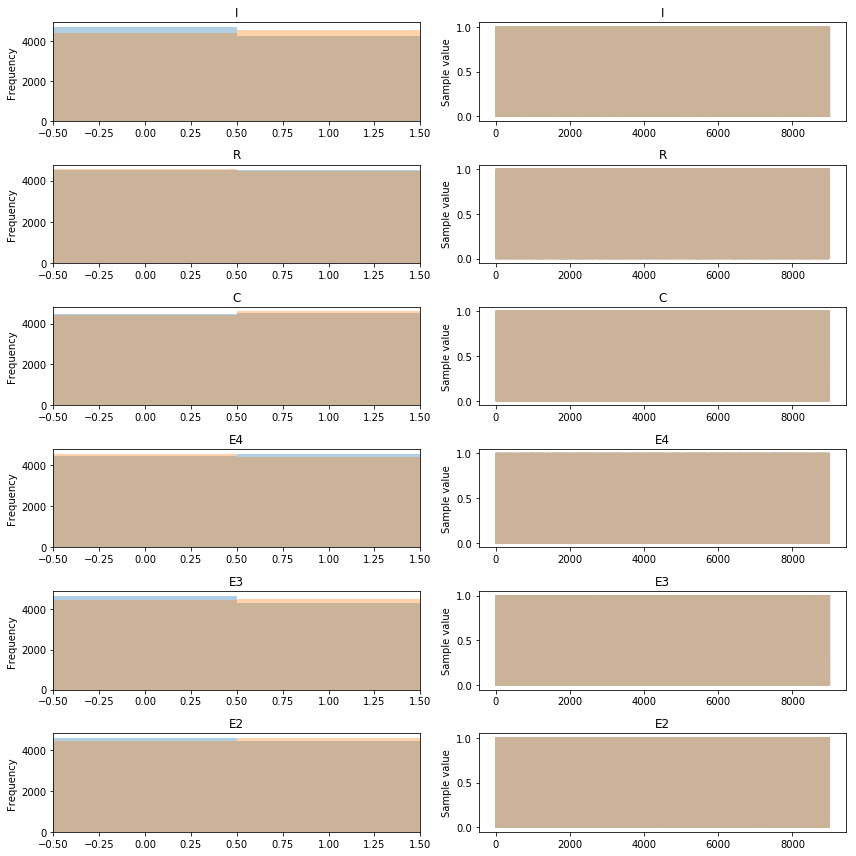

In [94]:
pm.traceplot(trace[1000:], varnames=['I', 'R', 'C', 'E4', 'E3', 'E2'])

In [95]:
summary = pm.summary(trace)
summary

C:\Users\Daniela\Anaconda3.5\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
I,0.49545,0.499979,0.005698,0.0,1.0,7792.267702,1.000797
R,0.49910,0.499999,0.005564,0.0,1.0,7789.120728,1.000062
C,0.50580,0.499966,0.005568,0.0,1.0,8181.518949,0.999986
E4,0.50050,0.500000,0.005109,0.0,1.0,7789.807937,1.000289
E3,0.49455,0.499970,0.005560,0.0,1.0,7894.880406,1.000249
E2,0.49935,0.500000,0.005110,0.0,1.0,8684.510174,1.000216


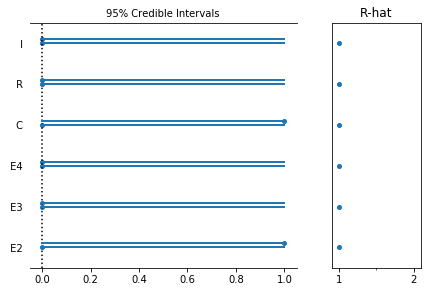

In [35]:
pm.forestplot(trace);

### NetworkX with PyMC3

In [26]:
import networkx as nx

In [60]:
dI_prob=np.array([0.5, 0.5]) #2 choices
dR_prob=np.array([0.5,0.5]) #2 choices
dC_prob=np.array([0.5,0.5]) #2 choices

de4_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])
de3_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])
de2_prob = np.array([[0.8, 0.2],  # (2x1)x2 choices
                    [0.2, 0.8]])   
                    
f3_prob = np.array([[[1.0, 0.0],  # (2x4)x2 choices
                     [0.8, 0.2], 
                     [1.0, 0.0],
                     [0.1, 0.9]], 
                    [[0.8, 0.2], 
                     [0.1, 0.9],
                     [0.8, 0.2],
                     [0.0, 1.0]]])

Now we can get on with instantiating the theano computation graph. Note that we are referencing each node as a location in a graph, and pulling the objects needed to caclulate parameters directly from the parent nodes, whatever those are.

In [96]:
BN=nx.DiGraph()
BN.add_node('I', dtype='Discrete', prob=dI_prob, pos=(3, 3))
BN.add_node('R', dtype='Discrete', prob=dR_prob, pos=(2, 3))
BN.add_node('C',dtype='Discrete', prob=dC_prob, pos=(1,2))
BN.add_node('E4', dtype='Discrete', prob=de4_prob, pos=(2,2))
BN.add_edge('R', 'E4')
BN.add_node('E3', dtype='Discrete', prob = de3_prob, pos=(3, 2))
BN.add_edge('I', 'E3')
BN.add_node('E2', dtype='Discrete', prob = de2_prob, pos=(3, 1))
BN.add_node('F2', dtype='Discrete', prob=f3_prob, observe=np.array([0]), pos=(2, 1))
BN.add_edges_from([('E4', 'F2'), ('E3', 'F2')])
BN.add_edge('F2', 'E2')
BN.add_edge('C', 'F2')

In [97]:
BN.nodes(data=True)

NodeDataView({'I': {'dtype': 'Discrete', 'prob': array([0.5, 0.5]), 'pos': (3, 3)}, 'R': {'dtype': 'Discrete', 'prob': array([0.5, 0.5]), 'pos': (2, 3)}, 'C': {'dtype': 'Discrete', 'prob': array([0.5, 0.5]), 'pos': (1, 2)}, 'E4': {'dtype': 'Discrete', 'prob': array([[0.8, 0.2],
       [0.2, 0.8]]), 'pos': (2, 2)}, 'E3': {'dtype': 'Discrete', 'prob': array([[0.8, 0.2],
       [0.2, 0.8]]), 'pos': (3, 2)}, 'E2': {'dtype': 'Discrete', 'prob': array([[0.8, 0.2],
       [0.2, 0.8]]), 'pos': (3, 1)}, 'F2': {'dtype': 'Discrete', 'prob': array([[[1. , 0. ],
        [0.8, 0.2],
        [1. , 0. ],
        [0.1, 0.9]],

       [[0.8, 0.2],
        [0.1, 0.9],
        [0.8, 0.2],
        [0. , 1. ]]]), 'observe': array([0]), 'pos': (2, 1)}})

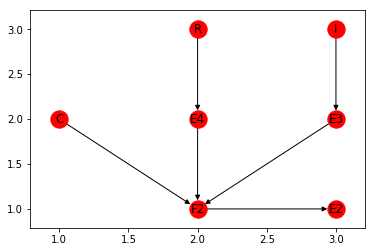

In [98]:
nx.draw_networkx(BN, pos=nx.get_node_attributes(BN,'pos'))

In [105]:
# utily to quickly access the parent nodes' pymc3 objects
def activate_node(g, start_node, num=0):          
    stack = [start_node]

    while stack:
        node = stack.pop()
        preds = list(g.predecessors(node))
        #stack += preds
        
        #print('%s -> %s' % (node, preds[1]))
        return g.node[preds[num]]['dist_obj']

with pm.Model() as mod2:
    
    BN.nodes['I']['dist_obj'] = pm.Categorical('I',p=BN.node['I']['prob'])
    BN.nodes['R']['dist_obj'] = pm.Categorical('R',p=BN.node['R']['prob'])
    
    BN.nodes['C']['dist_obj'] = pm.Categorical('C',p=BN.node['C']['prob'])
                                         
    BN.nodes['E4']['dist_obj'] =  pm.Categorical('E4',p=theano.shared(BN.node['E4']['prob']))
    BN.nodes['E3']['dist_obj'] = pm.Categorical('E3', p=theano.shared(BN.node['E3']['prob']))
    BN.nodes['E2']['dist_obj'] =  pm.Categorical('E2',p=theano.shared(BN.node['E2']['prob']))
    BN.nodes['F2']['dist_obj'] =  pm.Categorical('F2', p=theano.shared(BN.node['F2']['prob'])[
        activate_node(BN,'F2', num=1),
        activate_node(BN,'F2', num=0)
    ], observed=BN.nodes['F2']['observe'])
   # BN['C3']['D4']['bin']=T.switch(T.lt(activate_node(BN,'D4'),9), 0, 
                                         # T.switch(T.gt(activate_node(BN,'D4'), 9) & T.lt(activate_node(BN,'D4'),11), 1, 2))
   
    #BN.nodes['D4']['dist_obj'] =pm.Categorical('D4', p=theano.shared(BN.nodes['D4']['prob'])[
      # [0],[0]], observed=BN.nodes['D4']['observe'])

C:\Users\Daniela\Anaconda3.5\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [106]:
with mod2:
 trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [I, R, C, E4, E3, E2]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:33<00:00, 225.17draws/s]
C:\Users\Daniela\Anaconda3.5\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [107]:
summary = pm.summary(trace)
summary

C:\Users\Daniela\Anaconda3.5\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
I,0.50190,0.499996,0.001898,0.0,1.0,74146.109891,0.999951
R,0.49780,0.499995,0.001869,0.0,1.0,76497.277477,0.999954
C,0.49810,0.499996,0.001786,0.0,1.0,92149.263438,0.999953
E4,0.33485,0.471938,0.002311,0.0,1.0,29230.443035,0.999971
E3,0.33290,0.471251,0.002662,0.0,1.0,27900.172253,0.999974
E2,0.50035,0.500000,0.001771,0.0,1.0,74762.194009,0.999962
